# Case Study 12: Higgs Boson Replica Neural Network




# Methods

The first 10.5 MM rows are trained and validated with a 9:1 ratio and the last 500 rows are tested for accuracy, precision, recall and ROC score metrics, not unlike the classification models we ran previously. With the use of tools such as Tensorflow, we can optimize parameters for number of layers, neurons (units), activation function, batch size, kernel initializer, optimizer, learning rate, epsilon, decay rate, and dropout rate. With these optimized parameters, the final model will expand the the number of default epochs from 20 to 500 with early stopping to find the highest ROC score. 

To give a little more detail on the parameters we are looking to optimize, see below:

* No. of Layers - While a single layer can be used to learn problems, utilizing multiple layers allows us to ease the process of our models learning using multilayer perceptrons. 
* No. of Neurons - like layers, add to the complexity of a model in helping it learn
* Activation Function - part of a node that defines the output of that node given a set of inputs. 
* Batch Size - number of training examples in one forward/backward pass
* Kernel Initializer - define the way to set the initial random weights of keras layers
* Optimizer - one of two artguments required for compiling a keras module
* Learning Rate - a function that takes an epoch index and current learning rate (float) as inputs and returns a new learning rate
* Epsilon - the value of the fuzz factor used in numeric expression
* Decay Rate - reducing an amount by a consistent peercentage rate over a period of time. 
* Dropout Rate - excluding random inputs from each update cycle to ensure optimization. 

In [1]:
#pip install tensorflow

In [2]:
%matplotlib inline

import sys
try:
    sys.getwindowsversion()
except AttributeError:
    isWindows = False
else:
    isWindows = True
if isWindows:
    import win32api,win32process,win32con
    pid = win32api.GetCurrentProcessId()
    handle = win32api.OpenProcess(win32con.PROCESS_ALL_ACCESS, True, pid)
    win32process.SetPriorityClass(handle, win32process.ABOVE_NORMAL_PRIORITY_CLASS)
import warnings
warnings.filterwarnings('ignore')

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import SGD
import keras
from pprint import pprint
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import roc_auc_score

# in order to have reproducible result
from numpy.random import seed
import tensorflow
tensorflow.random.set_seed(2)


Using TensorFlow backend.


We implemented the get_metrics function that will retrive the current model's ROC, accuracy, precision, recall and F1-score metrics for the test dataset. 

We will build a net functiont hat will set the default parameters for a neural network if undefined in the code. This means we would move forward with a dropout of 0.1, activations is relu, uniform initializer, stochastic gradient descent optimizer, 0.1 learning rate, 1e-6 learning decay, 0.9 momentum, Nesterov method, 5000 batch size, and patience of 2 where accuracy and binary cross entropy loss functions are monitored for the training and validation datasets. 

Setting the default parameters in the train function will include an early stopping to find accuracy and validation accuracy of the current neural network per epoch for the training and validation datasets. 

In [3]:
def get_metrics(y_true, y_pred, treshhold=.5):
    RocAuc=metrics.roc_auc_score(y_test, y_pred)
    y_pred = (y_pred > treshhold).astype(np.int32)
    return dict(
        RocAuc="{:.4f}".format(metrics.roc_auc_score(y_test, y_pred)),
        Accuracy="{:.4f}".format(metrics.accuracy_score(y_test, y_pred)),
        Precision="{:.4f}".format(metrics.precision_score(y_test, y_pred)),
        Recall="{:.4f}".format(metrics.recall_score(y_test, y_pred)),
        F1="{:.4f}".format(metrics.f1_score(y_test, y_pred))
    )

def net(units,
        dropouts=.1,
        activations=None,
        kernel_initializers='uniform',
        optimizer=None
    ):

    input_dim = x.shape[1]
    assert type(units) == list and len(units) and units[-1] == 1
    units = units[:]
    if activations == None:
        activations = ['relu' for _ in units]
        activations[-1] = 'sigmoid'
    activations = activations[:]
    if type(dropouts) != list:
        dropouts = [dropouts for _ in range(len(units)-1)]
    dropouts = dropouts[:]
    if type(kernel_initializers) != list:
        kernel_initializers = [kernel_initializers for _ in units]
    kernel_initializers = kernel_initializers[:]
    assert len(units) == len(kernel_initializers) == len(activations) == len(dropouts)+1
    if optimizer is None:
        optimizer = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
        
    model = Sequential()
    
    # first layer is special so it is out of the loop
    unit = units.pop(0)
    activation = activations.pop(0)
    try:
        dropout = dropouts.pop(0)
    except:
        dropout = 0.
    kernel_initializer = kernel_initializers.pop(0)
    
    model.add(Dense(unit, input_dim=input_dim, kernel_initializer=kernel_initializer))
    if activation:
        model.add(Activation(activation))
    if dropout:
        model.add(Dropout(dropout))
    
    for unit in units:
        activation = activations.pop(0)
        try:
            dropout = dropouts.pop(0)
        except:
            dropout = 0.
        kernel_initializer = kernel_initializers.pop(0)
        
        model.add(Dense(unit, kernel_initializer=kernel_initializer))
        if activation:
            model.add(Activation(activation))
        if dropout:
            model.add(Dropout(dropout))

    model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=optimizer)
    return model

default_epochs = 20

def train(model, epochs=default_epochs, batch_size=5000, checkpoint=False, patience=2):
    history = keras.callbacks.History()
    early_stop = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta=0,
        patience=patience,
        verbose=0,
        mode='auto')
    
    callbacks = [history, early_stop]
    
    if checkpoint:
        filepath="weights.best.hdf5"
        checkpoint = keras.callbacks.ModelCheckpoint(
            filepath='best.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')
      #  callbacks.append(checkpoint)
    
    model.fit(x, y, epochs=epochs, batch_size=batch_size, callbacks=callbacks, validation_split=.1)
    result = pd.DataFrame(history.history)
    del result['loss']
    del result['val_loss']
    result = result.rename(columns={
        'acc': 'Train Accuracy',
        'val_acc': 'Validation Accuracy',
        'loss': 'Train Loss',
        'val_loss': 'Validation Loss',
    })
    index = pd.Index(np.arange(epochs), name='Epoch')
    result.reindex(index)
    result.index += 1
    result.index.name = 'Epoch'
    result.columns.name = 'Accuracy'
    return result

## Results

To help with the computing power with regards to the size of the dataset, we will convert our default imported float64 values to the float16 to make oiur memory usage more efficient. Our table below shows how our float16 will maintain data integrity while reducing the memory to 608.4 MB. 

In [4]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00280/HIGGS.csv.gz
!gunzip *.gz

data=pd.read_csv("HIGGS.csv",header=None, dtype=np.float64, engine='c')
data.columns=['label','lepton pt','lepton eta','lepton phi','missing energy magnitude','missing energy phi',
              'jet 1 pt','jet 1 eta','jet 1 phi','jet 1 b-tag','jet 2 pt','jet 2 eta','jet 2 phi','jet 2 b-tag',
              'jet 3 pt','jet 3 eta','jet 3 phi','jet 3 b-tag','jet 4 pt','jet 4 eta','jet 4 phi','jet 4 b-tag',
              'm_jj','m_jjj','m_lv','m_jlv','m_bb','m_wbb','m_wwbb']

data1 = data.max()-data.min()
data=data.astype('float16')
data.info()

--2020-07-26 13:31:38--  https://archive.ics.uci.edu/ml/machine-learning-databases/00280/HIGGS.csv.gz
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2816407858 (2.6G) [application/x-httpd-php]
Saving to: ‘HIGGS.csv.gz’

HIGGS.csv.gz        100%[===================>]   2.62G  17.9MB/s    in 2m 33s  

2020-07-26 13:34:12 (17.5 MB/s) - ‘HIGGS.csv.gz’ saved [2816407858/2816407858]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11000000 entries, 0 to 10999999
Data columns (total 29 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   label                     float16
 1   lepton pt                 float16
 2   lepton eta                float16
 3   lepton phi                float16
 4   missing energy magnitude  float16
 5   missing energy phi        float16
 6   jet 1 pt           

In [5]:
#!pip install pandas-profiling==2.7.1
#conda install -c conda-forge/label/cf202003 pandas-profiling

In [6]:
data2 = data.max()-data.min()

#memory = pd.concat([data1, data2], axis=1, join_axes=[data1.index])
memory = pd.concat([data1, data2], axis=1)
memory.columns=['Before','After']
print('Table 1: Data Min and Max from Float64 to Float16')
memory

Table 1: Data Min and Max from Float64 to Float16


,Before,After
label,1.000000,1.000000
lepton pt,11.824217,11.828125
lepton eta,4.869844,4.871094
lepton phi,3.485744,3.484375
missing energy magnitude,15.396584,15.398438
missing energy phi,3.487201,3.488281
jet 1 pt,9.802888,9.796875
jet 1 eta,5.939399,5.937500
jet 1 phi,3.482691,3.482422
jet 1 b-tag,2.173076,2.173828


## Table 1: Float 16 still preserves the data integrity compared to that of float64

We plotted all 28 varlables to see how the distrubtions of numerical and categrotical variables to see how much loss we had to the data from converting to a float64 to a float16. Here, we can see that the loss is minimal. 



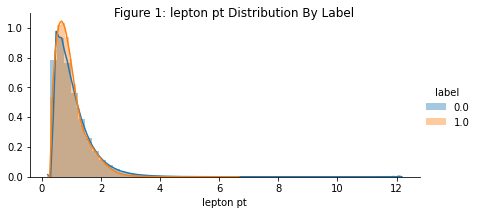

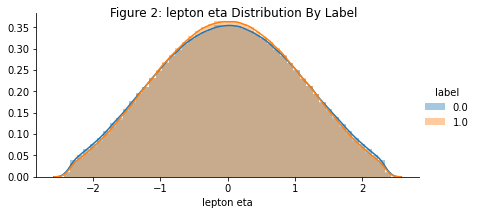

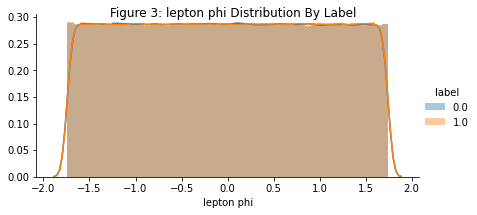

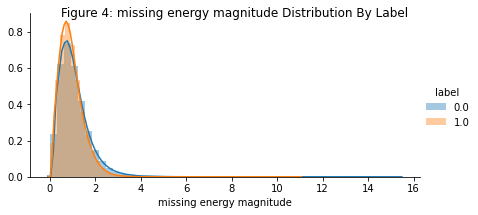

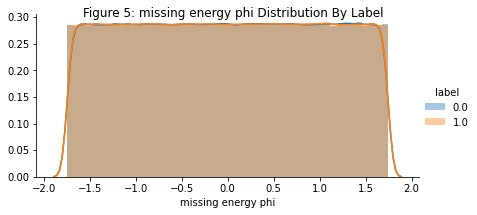

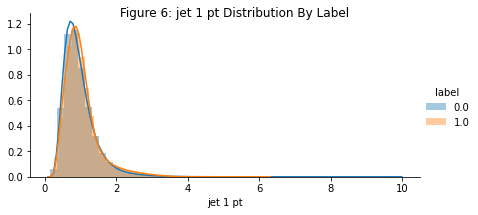

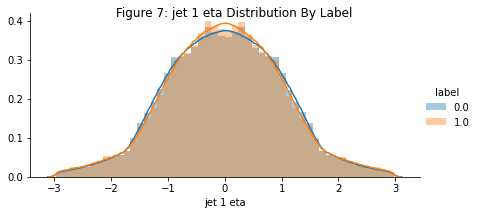

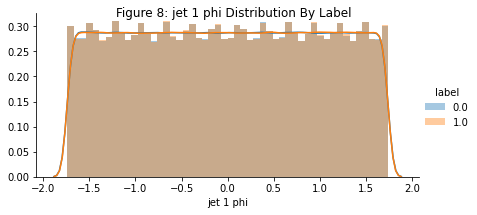

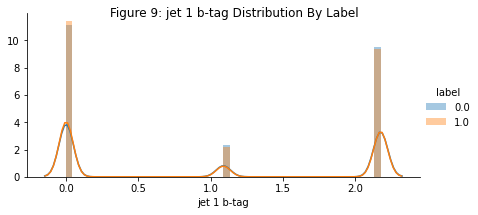

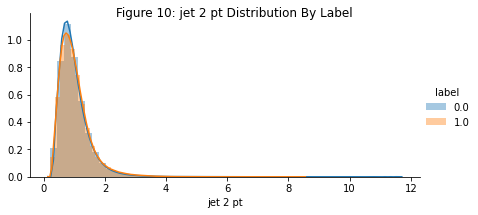

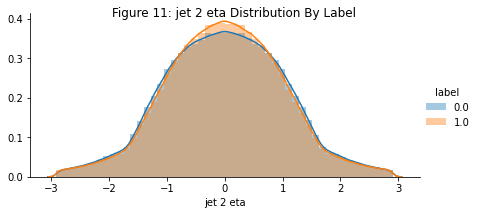

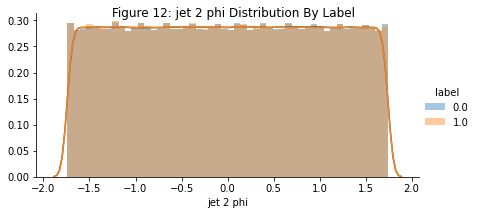

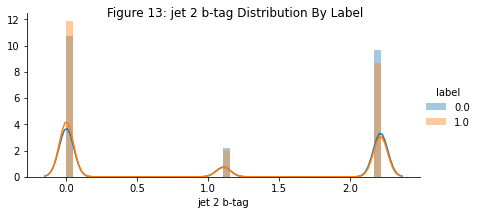

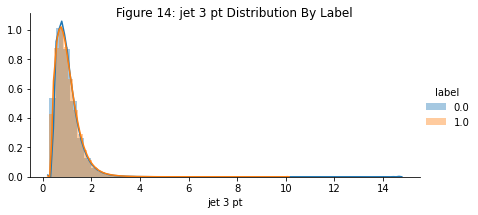

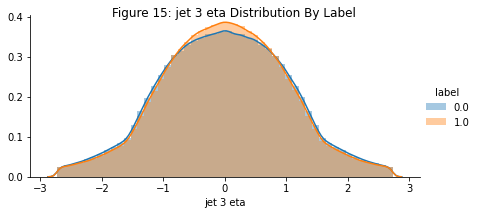

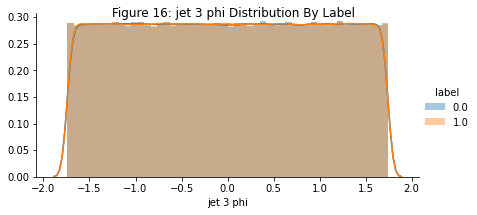

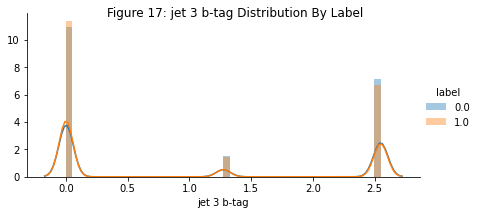

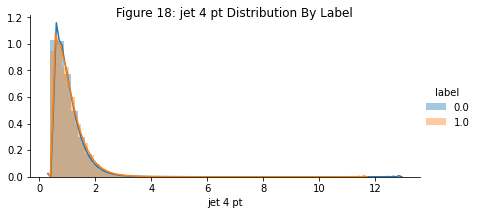

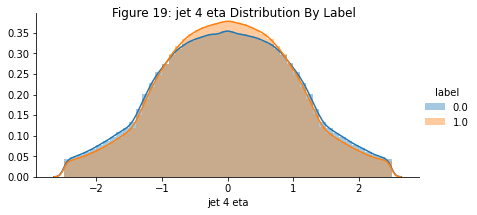

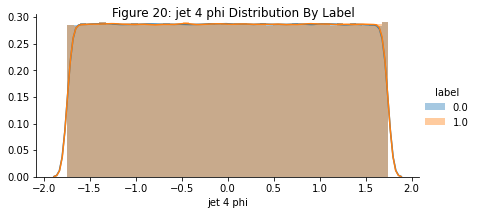

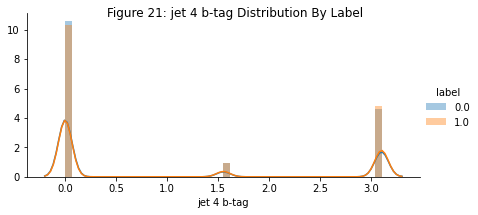

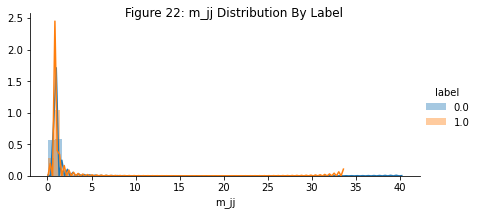

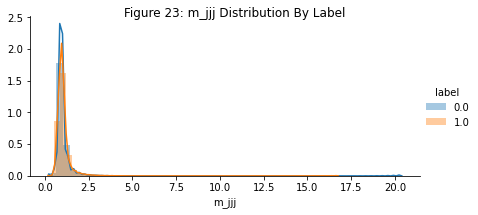

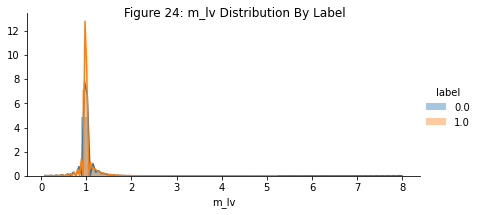

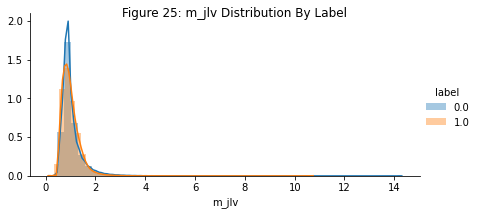

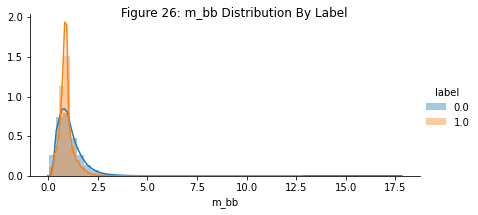

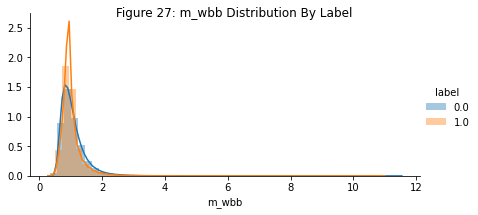

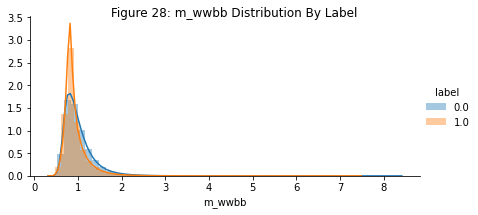

In [7]:
plt.rcParams['figure.max_open_warning']=40
colnames=list(data.columns.values)
for i in colnames[1:]:
    facet = sns.FacetGrid(data, hue='label',aspect=2).set_titles(i)
    facet.map(sns.distplot,i)
    facet.add_legend()
    Title=str(["Figure ",colnames.index(i),": ",i," Distribution By Label"])
    facet.fig.suptitle(''.join(map(str, list(["Figure ",colnames.index(i),": ",i," Distribution By Label"]))))
    plt.show()

In figure 1 through 28, we an see that we have an array of normal and skewed distributions between each of our varaibles at play. 

Next, let's look at a heatmap of correlations between variables and the Higgs Boson label. The only positive correlation as well as the last 7 derivative kinematic variables which show strong long relations. 

[Figure 29]

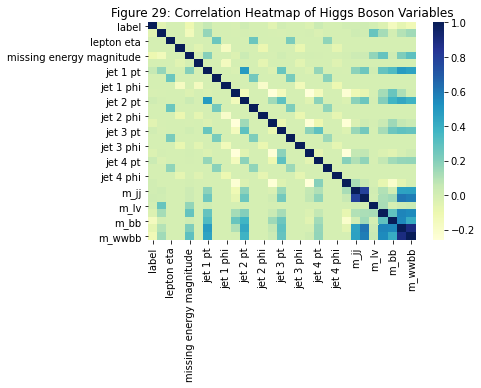

In [8]:
ax = plt.axes()
sns.heatmap(data.corr(), cmap="YlGnBu", ax = ax)
ax.set_title('Figure 29: Correlation Heatmap of Higgs Boson Variables')
plt.show()

Figure 29: Most variables are weekly correlated with the Higgs Boson Label for the last 7 variables having any real correlation. 

We will now split our training and testing datasets into the target and predictor variables at y and x. This will balance our target variable at .05 so that we can choose accuracy as the target metric. 

In [9]:
# labels must be 0 or 1 and not in between
assert not ((data["label"]>0)&(data["label"]<1)).sum()
data["label"] = data["label"].astype(np.int16)

test_data = data.iloc[-500000:].copy()
data = data.iloc[:-500000]

y = np.array(data.iloc[:,0])
x = np.array(data.iloc[:,1:])

x_test = np.array(test_data.iloc[:,1:])
y_test = np.array(test_data.iloc[:,0])

del test_data, data
y.mean()

0.5299634285714285

The ROC accuracy of our baseline layer and neurode count shows a 0.5 with a high recall, which explains the impact to the F1 score. 

In [10]:
model = net([1])
print("Test Dataset :", get_metrics(y_test, model.predict(x_test)))

Test Dataset : {'RocAuc': '0.4933', 'Accuracy': '0.4818', 'Precision': '0.5180', 'Recall': '0.2950', 'F1': '0.3759'}


## 1. Pick 3 or more different architectures (add/subtract layers + neurons) and run the model + score. 

### Number of Layers Search

The default activation is relu to optimize the layers of our neural nethwork by way of the sigmoid havng vanishing gradients that do not work well as relu or elu. We will incomroporate 50 neurons to optimize for layers. 

In [11]:
hparams = []
for layers in range(1,5):
    hparams.append(
        dict(units=[50]*layers+[1])
    )
print('Testing Hyperparameters:')
pprint(hparams)

trainAcc_layers = {}
valAcc_layers = {}

Testing Hyperparameters:
[{'units': [50, 1]},
 {'units': [50, 50, 1]},
 {'units': [50, 50, 50, 1]},
 {'units': [50, 50, 50, 50, 1]}]


In [12]:
hparams = []
for layers in range(1,5):
    hparams.append(
        dict(units=[50]*layers+[1])
    )
print('Testing Hyperparameters:')
pprint(hparams)

trainAcc_layers = {}
valAcc_layers = {}

for hparam in hparams:
    title = "Hyper Params: %s" % str(hparam)
    print(title)
    model = net(**hparam)
    result = train(model)
    trainAcc_layers[title] = result['accuracy']
    valAcc_layers[title] = result['val_accuracy']
    print("Test Dataset :", get_metrics(y_test, model.predict(x_test)))

Testing Hyperparameters:
[{'units': [50, 1]},
 {'units': [50, 50, 1]},
 {'units': [50, 50, 50, 1]},
 {'units': [50, 50, 50, 50, 1]}]
Hyper Params: {'units': [50, 1]}
Train on 9450000 samples, validate on 1050000 samples
Epoch 1/20
9450000/9450000 [==============================] - 15s 2us/step - loss: 0.6008 - accuracy: 0.6745 - val_loss: 0.5714 - val_accuracy: 0.7042
Epoch 2/20
9450000/9450000 [==============================] - 15s 2us/step - loss: 0.5737 - accuracy: 0.7018 - val_loss: 0.5596 - val_accuracy: 0.7134
Epoch 3/20
9450000/9450000 [==============================] - 15s 2us/step - loss: 0.5656 - accuracy: 0.7082 - val_loss: 0.5614 - val_accuracy: 0.7161
Epoch 4/20
9450000/9450000 [==============================] - 15s 2us/step - loss: 0.5611 - accuracy: 0.7116 - val_loss: 0.5480 - val_accuracy: 0.7215
Epoch 5/20
9450000/9450000 [==============================] - 15s 2us/step - loss: 0.5590 - accuracy: 0.7129 - val_loss: 0.5461 - val_accuracy: 0.7230
Epoch 6/20
9450000/945000

### Layers Search Result

The accuracy increases as more layers are added across the 20 epochs we are using. Using 3 layers of 50 neurons, we saw that there's overfitting int he 4th layer where accuracy stopped as the model failed to continue learning from the training set [fig 30]. Therefore, the best number of layers is 3 with an accuracy of 0.7422 and the validation accuracy of 0.7519.

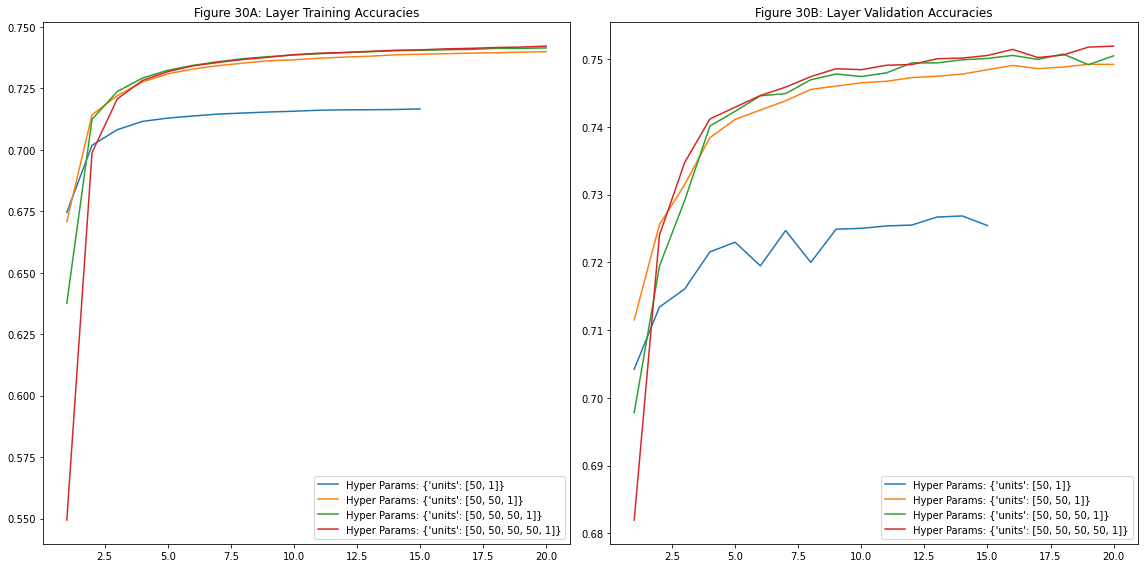

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,8))

pd.DataFrame(trainAcc_layers).plot(title='Figure 30A: Layer Training Accuracies', ax=axes[0])
pd.DataFrame(valAcc_layers).plot(title='Figure 30B: Layer Validation Accuracies', ax=axes[1])
plt.tight_layout()

In [14]:
best_n_layers = 3

### Number of Neurons 

We will use the 3 layers we had success with in our previous model, and increase the number of neurons for each layer. We will increase by the same number of neurons to optimize for accuracy and F1 score. 

In [16]:
hparams = []

for units in [100, 200, 400, 800]:
    hparams.append(
        dict(units=[units]*best_n_layers+[1])
    )
    
print('Testing Hyperparameters:')
pprint(hparams)

trainAcc_dense = {}
valAcc_dense = {}

for hparam in hparams:
    title = "Hyperparameters: %s" % str(hparam)
    print(title)
    
    model = net(**hparam)
    result = train(model, epochs=5)
    trainAcc_dense[title] = result['accuracy']
    valAcc_dense[title] = result['val_accuracy']
    print("Test Dataset :", get_metrics(y_test, model.predict(x_test)))

Testing Hyperparameters:
[{'units': [100, 100, 100, 1]},
 {'units': [200, 200, 200, 1]},
 {'units': [400, 400, 400, 1]},
 {'units': [800, 800, 800, 1]}]
Hyperparameters: {'units': [100, 100, 100, 1]}
Train on 9450000 samples, validate on 1050000 samples
Epoch 1/5
9450000/9450000 [==============================] - 17s 2us/step - loss: 0.5991 - accuracy: 0.6661 - val_loss: 0.5648 - val_accuracy: 0.7048
Epoch 2/5
9450000/9450000 [==============================] - 17s 2us/step - loss: 0.5427 - accuracy: 0.7213 - val_loss: 0.5214 - val_accuracy: 0.7360
Epoch 3/5
9450000/9450000 [==============================] - 17s 2us/step - loss: 0.5257 - accuracy: 0.7331 - val_loss: 0.5093 - val_accuracy: 0.7439
Epoch 4/5
9450000/9450000 [==============================] - 17s 2us/step - loss: 0.5175 - accuracy: 0.7387 - val_loss: 0.5032 - val_accuracy: 0.7483
Epoch 5/5
9450000/9450000 [==============================] - 17s 2us/step - loss: 0.5126 - accuracy: 0.7420 - val_loss: 0.4984 - val_accuracy: 0.7

### Number of neurons search result

Accuracy and F1-Score are the highest in the batch of 800 neurons per layer with an accuracy maxing out at 0.7602 [Fig. 31]. The time spent to run each batch increased up to 800, so we will set to 100 neurons moving forward to save time to allow us to optimize the parameters to the final model. 

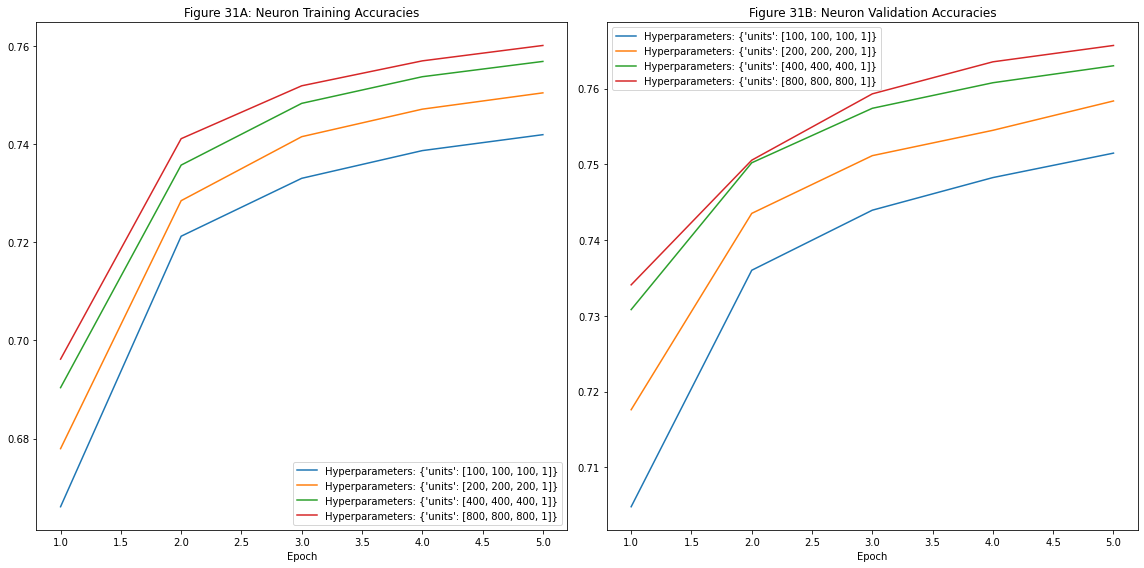

In [17]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,8))

pd.DataFrame(trainAcc_dense).plot(title='Figure 31A: Neuron Training Accuracies', ax=axes[0])
pd.DataFrame(valAcc_dense).plot(title='Figure 31B: Neuron Validation Accuracies', ax=axes[1])
plt.tight_layout()

### Fig. 31: The most accurate number of neurons is 800 with a training accuracy of 0.760 and a validation accuracy of 0.766.

In [18]:
#still 800, reduced to 100 to save time and processing
best_n_units = 100

## 2. With those 3 architectures, we can run the same architecture with 2 different sigmoid activation functions. 

### Activations Search

The default optimization activation is rely for classification because sigmoid and tanh have vanishing gradients that do not work as well as relu or elu on deeper networks. 

In [19]:
hparams = []
for activation in ['elu', 'relu', 'selu']:
    hparams.append(
        dict(
            units=[best_n_units]*best_n_layers+[1],
            activations=[activation]*best_n_layers+['sigmoid'],
        )
    )

print('Testing Hyperparameters:')
pprint(hparams)

trainAcc_activation = {}
valAcc_activation = {}

for hparam in hparams:
    title = "Hyperparameters: %s" % str(hparam)
    print(title)
    model = net(**hparam)
    result = train(model, epochs=5)
    trainAcc_activation[title] = result['accuracy']
    valAcc_activation[title] = result['val_accuracy']
    print("Test Dataset :", get_metrics(y_test, model.predict(x_test)))

Testing Hyperparameters:
[{'activations': ['elu', 'elu', 'elu', 'sigmoid'], 'units': [100, 100, 100, 1]},
 {'activations': ['relu', 'relu', 'relu', 'sigmoid'],
  'units': [100, 100, 100, 1]},
 {'activations': ['selu', 'selu', 'selu', 'sigmoid'],
  'units': [100, 100, 100, 1]}]
Hyperparameters: {'units': [100, 100, 100, 1], 'activations': ['elu', 'elu', 'elu', 'sigmoid']}
Train on 9450000 samples, validate on 1050000 samples
Epoch 1/5
9450000/9450000 [==============================] - 16s 2us/step - loss: 0.6292 - accuracy: 0.6417 - val_loss: 0.5924 - val_accuracy: 0.6837
Epoch 2/5
9450000/9450000 [==============================] - 16s 2us/step - loss: 0.5880 - accuracy: 0.6857 - val_loss: 0.5711 - val_accuracy: 0.6992
Epoch 3/5
9450000/9450000 [==============================] - 16s 2us/step - loss: 0.5715 - accuracy: 0.6993 - val_loss: 0.5584 - val_accuracy: 0.7097
Epoch 4/5
9450000/9450000 [==============================] - 16s 2us/step - loss: 0.5624 - accuracy: 0.7062 - val_loss: 0.

### Activations Search Result

Relu proved to be the most accurate function with a training set accuracy of 0.74 with a validation test accuracy of 0.75.

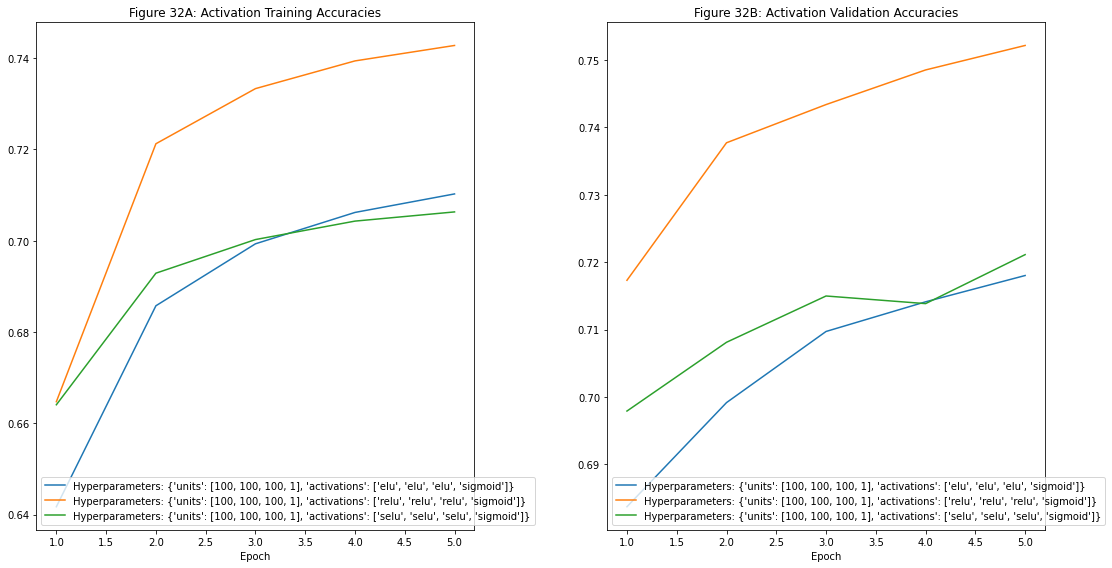

In [20]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,8))

pd.DataFrame(trainAcc_activation).plot(title='Figure 32A: Activation Training Accuracies', ax=axes[0])
pd.DataFrame(valAcc_activation).plot(title='Figure 32B: Activation Validation Accuracies', ax=axes[1])
plt.tight_layout()

### Figure 32: Relu is the best activation function by far as opposed to elu and selu. 

In [21]:
best_activation = 'relu'

### 3. Take the best model from 1 and 2 and vary the batch size by at least 2 orders of magnitude. 

#### Batch Size Search

Let's range our batch sizes from 500 to 5000 to see where we are getting our best validation accuracy.

In [22]:
best_hparam = dict(
    units=[best_n_units]*best_n_layers+[1],
    activations=[best_activation]*best_n_layers+['sigmoid'],
)

trainAcc_batch = {}
valAcc_batch = {}

for batch_size in 500, 1000, 50000:
    title = "Batch Size: %d" % batch_size
    print(title)
    model = net(**best_hparam)
    result = train(model, batch_size=batch_size, epochs=10)
    trainAcc_batch[title] = result['accuracy']
    valAcc_batch[title] = result['val_accuracy']
    print("Test Dataset :", get_metrics(y_test, model.predict(x_test)))

Batch Size: 500
Train on 9450000 samples, validate on 1050000 samples
Epoch 1/10
9450000/9450000 [==============================] - 67s 7us/step - loss: 0.5507 - accuracy: 0.7136 - val_loss: 0.5146 - val_accuracy: 0.7406
Epoch 2/10
9450000/9450000 [==============================] - 66s 7us/step - loss: 0.5189 - accuracy: 0.7381 - val_loss: 0.5048 - val_accuracy: 0.7473
Epoch 3/10
9450000/9450000 [==============================] - 66s 7us/step - loss: 0.5121 - accuracy: 0.7426 - val_loss: 0.5002 - val_accuracy: 0.7517
Epoch 4/10
9450000/9450000 [==============================] - 66s 7us/step - loss: 0.5087 - accuracy: 0.7451 - val_loss: 0.4940 - val_accuracy: 0.7547
Epoch 5/10
9450000/9450000 [==============================] - 67s 7us/step - loss: 0.5063 - accuracy: 0.7467 - val_loss: 0.4931 - val_accuracy: 0.7558
Epoch 6/10
9450000/9450000 [==============================] - 66s 7us/step - loss: 0.5046 - accuracy: 0.7478 - val_loss: 0.4925 - val_accuracy: 0.7560
Epoch 7/10
9450000/94500

### Batch Size Search Result

The batch size of 1000 had the strongest training set accuracy of 0.75 and a validation accuracy of 0.76.

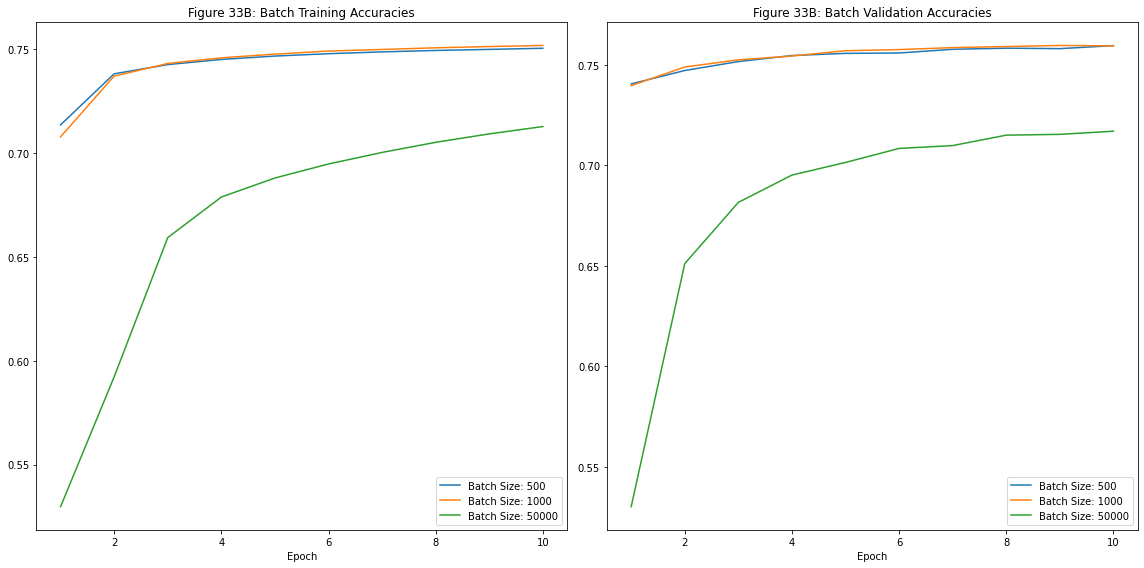

In [23]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,8))

pd.DataFrame(trainAcc_batch).plot(title='Figure 33B: Batch Training Accuracies', ax=axes[0])
pd.DataFrame(valAcc_batch).plot(title='Figure 33B: Batch Validation Accuracies', ax=axes[1])
plt.tight_layout()

#### Figure 33: A batch size of 1000 gives us the highest accuracy set and validation accuacy. 

In [24]:
best_batch_size = 1000

### Take our best models (based on scores) from parts 1 and 2 and use 3 different kernel initializers with a reasonable batch size (to keep computation costs low).

#### Kernel Initializer  Search

Initializers for classification models perform better when we have normal distributions in our variables rather than uniform distributions. So we will only focus on initializers with normal distrubtions as well as variance scaling and orthogonal. 

In [25]:
best_hparam = dict(
    units=[best_n_units]*best_n_layers+[1],
    activations=[best_activation]*best_n_layers+['sigmoid'],
)

trainAcc_initial = {}
valAcc_initial = {}

for kernel_initializer in ['VarianceScaling','orthogonal','random_normal','truncated_normal',
                           'glorot_normal','lecun_normal','he_normal']:
    title = "Kernel Initializers: %s" % kernel_initializer
    best_hparam['kernel_initializers'] = kernel_initializer
    print(title)
    
    model = net(**best_hparam)
    result = train(model, batch_size=best_batch_size, epochs=10)
    trainAcc_initial[title] = result['accuracy']
    valAcc_initial[title] = result['val_accuracy']
    print("Test Dataset :", get_metrics(y_test, model.predict(x_test)))

Kernel Initializers: VarianceScaling
Train on 9450000 samples, validate on 1050000 samples
Epoch 1/10
9450000/9450000 [==============================] - 40s 4us/step - loss: 0.5585 - accuracy: 0.7075 - val_loss: 0.5175 - val_accuracy: 0.7385
Epoch 2/10
9450000/9450000 [==============================] - 40s 4us/step - loss: 0.5237 - accuracy: 0.7350 - val_loss: 0.5083 - val_accuracy: 0.7459
Epoch 3/10
9450000/9450000 [==============================] - 40s 4us/step - loss: 0.5156 - accuracy: 0.7405 - val_loss: 0.4990 - val_accuracy: 0.7516
Epoch 4/10
9450000/9450000 [==============================] - 40s 4us/step - loss: 0.5110 - accuracy: 0.7435 - val_loss: 0.4946 - val_accuracy: 0.7547
Epoch 5/10
9450000/9450000 [==============================] - 41s 4us/step - loss: 0.5079 - accuracy: 0.7457 - val_loss: 0.4941 - val_accuracy: 0.7553
Epoch 6/10
9450000/9450000 [==============================] - 40s 4us/step - loss: 0.5058 - accuracy: 0.7471 - val_loss: 0.4909 - val_accuracy: 0.7574
Epo

References: 

https://www.heatonresearch.com/2017/06/01/hidden-layers.html#:~:text=Traditionally%2C%20neural%20networks%20only%20had,(not%20the%20next%20layer).

https://papers.nips.cc/paper/6372-learning-the-number-of-neurons-in-deep-networks.pdf

https://keras.io/api/layers/initializers/

https://www.thoughtco.com/exponential-decay-definition-2312215#:~:text=In%20mathematics%2C%20exponential%20decay%20describes,of%20time%20that%20has%20passed.